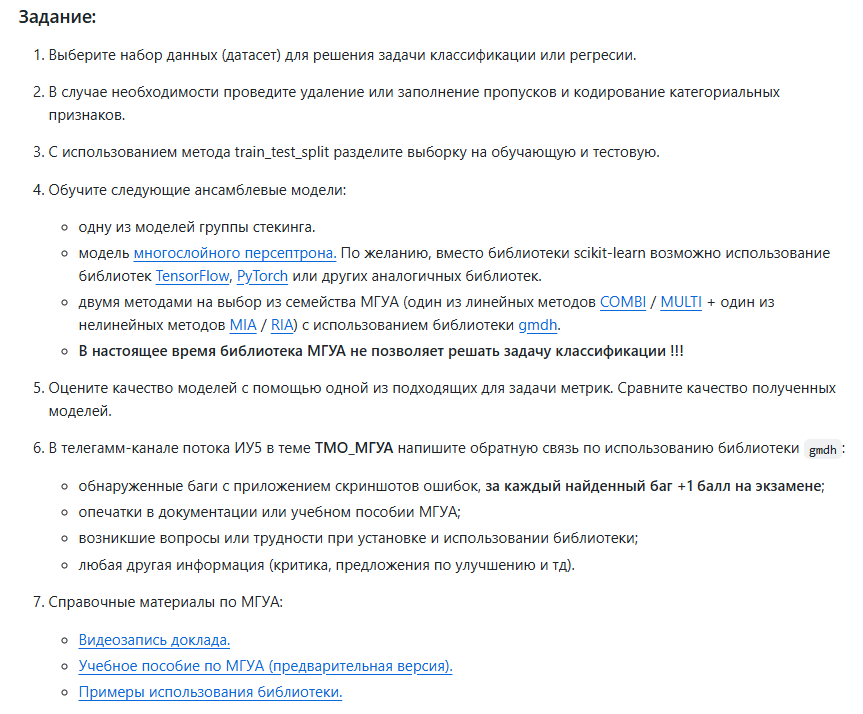

In [2]:
!pip install gmdh

Defaulting to user installation because normal site-packages is not writeable
  Using cached gmdh-1.0.3-cp39-cp39-win_amd64.whl (361 kB)
  Using cached docstring_inheritance-2.2.2-py3-none-any.whl (24 kB)


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Метрики
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
from itertools import combinations
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from gmdh import Combi, Ria, CriterionType, Criterion
import gmdh

In [7]:
df = pd.read_csv("gym_members_exercise_tracking.csv")
df.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


In [8]:
# Кодируем категориальные признаки 
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['Workout_Type'] = label_encoder.fit_transform(df['Workout_Type'])
df['Experience_Level'] = label_encoder.fit_transform(df['Experience_Level'])

### Масштабирование

In [9]:
numerical_features = ['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                      'Calories_Burned', 'Workout_Type', 'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'BMI']

In [10]:
scaler = StandardScaler()
scaler.fit(df[numerical_features]) # Обучаем StandardScaler на numerical_features
df[numerical_features] = scaler.transform(df[numerical_features]) # масштабируем числовые признаки

### Разделяем датасет

In [11]:
X = df.drop(['Experience_Level'], axis=1)
y_experience = df['Experience_Level']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_experience, test_size=0.2, random_state=42)
print('Train size:', X_train.shape[0])
print('Test_size:',X_test.shape[0])

Train size: 778
Test_size: 195


### Обучение модели группы стекинга

In [28]:
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values


estimators = [
    ('bagging', BaggingRegressor(random_state=52, n_estimators=100, n_jobs=-1)),
    ('svr', SVR()), # Нелинейная модель
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(random_state=52),
    cv=5,
    n_jobs=-1
)
stacking_model.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('bagging',
                               BaggingRegressor(n_estimators=100, n_jobs=-1,
                                                random_state=52)),
                              ('svr', SVR())],
                  final_estimator=Ridge(random_state=52), n_jobs=-1)

### Многослойный Перцептрон

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_test_scaled = scaler.transform(X_test_np)

mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42,
    alpha=0.0001,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=False
)
mlp_model.fit(X_train_scaled, y_train_np)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 50), max_iter=1000,
             random_state=42)

### COMBI

In [20]:
combi_model = Combi()
combi_model.fit(X_train_np, y_train_np, verbose=1)
# combi_model.fit(X_train2, y_train2, verbose=1)
# combi_model.fit(X_train_np[:3], y_train_np[:3])
print(f"Лучший полином COMBI: {combi_model.get_best_polynomial()}")

LEVEL 1  [=========================] 100% :00s] (14 combinations) error=62.75018                                    
LEVEL 2  [=========================] 100% :00s] (91 combinations) error=46.889351                                   
LEVEL 3  [=========================] 100% :00s] (364 combinations) error=43.028275                                  
LEVEL 4  [=========================] 100% :00s] (1001 combinations) error=42.306042                                 
LEVEL 5  [=========================] 100% :00s] (2002 combinations) error=42.289892                                 
LEVEL 6  [=========================] 100% :00s] (3003 combinations) error=42.273384                                 
LEVEL 7  [=========================] 100% :00s] (3432 combinations) error=42.25834                                  
LEVEL 8  [=========================] 100% :00s] (3003 combinations) error=42.264374                                 
Лучший полином COMBI: y = - 0.1054*x2 + 0.0064*x7 + 0.2382*x8 + 

### RIA

In [21]:
ria_model = Ria()
reg_criterion = Criterion(criterion_type=CriterionType.REGULARITY)
ria_model.fit(X_train_np, y_train_np, criterion=reg_criterion, k_best=5, p_average=3, verbose=1)
print(f"Лучший полином RIA: {ria_model.get_best_polynomial()}")

LEVEL 1  [=========================] 100% :00s] (91 combinations) error=47.189114                                   
LEVEL 2  [=========================] 100% :00s] (70 combinations) error=40.030278                                   
LEVEL 3  [=========================] 100% :00s] (70 combinations) error=38.050432                                   
LEVEL 4  [=========================] 100% :00s] (70 combinations) error=37.500863                                   
LEVEL 5  [=========================] 100% :00s] (70 combinations) error=36.827007                                   
LEVEL 6  [=========================] 100% :00s] (70 combinations) error=36.0647                                     
LEVEL 7  [=========================] 100% :00s] (70 combinations) error=35.617844                                   
LEVEL 8  [=========================] 100% :00s] (70 combinations) error=35.459699                                   
LEVEL 9  [=========================] 100% :00s] (70 combinations

### Оценка качества моделей

In [27]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

models_to_evaluate = {
    "Stacking": {'model': stacking_model, 'scaled': False},
    "MLP": {'model': mlp_model, 'scaled': True},
    "GMDH_COMBI" : {'model': combi_model, 'scaled': False},
    "GMDH_RIA" : {'model': ria_model, 'scaled': False}
}

metrics_results = {}

for name, info in models_to_evaluate.items():
    model = info['model']
    is_scaled = info['scaled']
    X_test_current = X_test_scaled if is_scaled else X_test_np
    y_pred = model.predict(X_test_current)

    # Расчет метрик
    r2 = r2_score(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    mse = mean_squared_error(y_test_np, y_pred)
    rmse = math.sqrt(mse)

    metrics_results[name] = {
        'R^2': r2,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }


metrics_df = pd.DataFrame(metrics_results).T
metrics_df = metrics_df[['R^2', 'MAE', 'MSE', 'RMSE']]
print(metrics_df.round(4))

               R^2     MAE     MSE    RMSE
Stacking    0.9032  0.1254  0.0562  0.2372
MLP         0.8005  0.2788  0.1160  0.3406
GMDH_COMBI  0.8353  0.2559  0.0958  0.3094
GMDH_RIA    0.8720  0.1947  0.0744  0.2728


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


### Результаты 5 Лабы

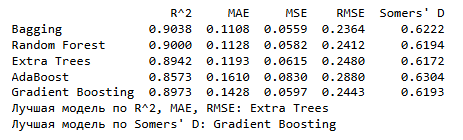

Bagging без стейкинга все равно оказался более подходящей моделью